In [1]:
import os
os.environ['KAGGLE_USERNAME'] = #'user'
os.environ['KAGGLE_KEY'] = #'key'

In [2]:
!kaggle datasets download -d navinmundhra/daily-power-generation-in-india-20172020

daily-power-generation-in-india-20172020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q daily-power-generation-in-india-20172020 -d .

replace ./State_Region_corrected.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
df = pd.read_csv('file_02.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   index                                 4945 non-null   int64  
 1   Date                                  4945 non-null   object 
 2   Region                                4945 non-null   object 
 3   Thermal Generation Actual (in MU)     4945 non-null   object 
 4   Thermal Generation Estimated (in MU)  4945 non-null   object 
 5   Nuclear Generation Actual (in MU)     2967 non-null   float64
 6   Nuclear Generation Estimated (in MU)  2967 non-null   float64
 7   Hydro Generation Actual (in MU)       4945 non-null   float64
 8   Hydro Generation Estimated (in MU)    4945 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 347.8+ KB


In [6]:
df = df[df.Region == 'Eastern']
df.head()

,index,Date,Region,Thermal Generation Actual (in MU),Thermal Generation Estimated (in MU),Nuclear Generation Actual (in MU),Nuclear Generation Estimated (in MU),Hydro Generation Actual (in MU),Hydro Generation Estimated (in MU)
3,3,2017-09-01,Eastern,441.02,429.39,NaN,NaN,85.94,69.36
8,8,2017-09-02,Eastern,441.02,425.75,NaN,NaN,85.94,74.18
13,13,2017-09-03,Eastern,445.38,427.61,NaN,NaN,85.94,71.05
18,18,2017-09-04,Eastern,445.38,450.85,NaN,NaN,85.94,75.21
23,23,2017-09-05,Eastern,449.92,459.09,NaN,NaN,85.94,70.29


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 3 to 4943
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   index                                 989 non-null    int64  
 1   Date                                  989 non-null    object 
 2   Region                                989 non-null    object 
 3   Thermal Generation Actual (in MU)     989 non-null    object 
 4   Thermal Generation Estimated (in MU)  989 non-null    object 
 5   Nuclear Generation Actual (in MU)     0 non-null      float64
 6   Nuclear Generation Estimated (in MU)  0 non-null      float64
 7   Hydro Generation Actual (in MU)       989 non-null    float64
 8   Hydro Generation Estimated (in MU)    989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 77.3+ KB


In [8]:
df.isnull().sum()

index                                     0
Date                                      0
Region                                    0
Thermal Generation Actual (in MU)         0
Thermal Generation Estimated (in MU)      0
Nuclear Generation Actual (in MU)       989
Nuclear Generation Estimated (in MU)    989
Hydro Generation Actual (in MU)           0
Hydro Generation Estimated (in MU)        0
dtype: int64

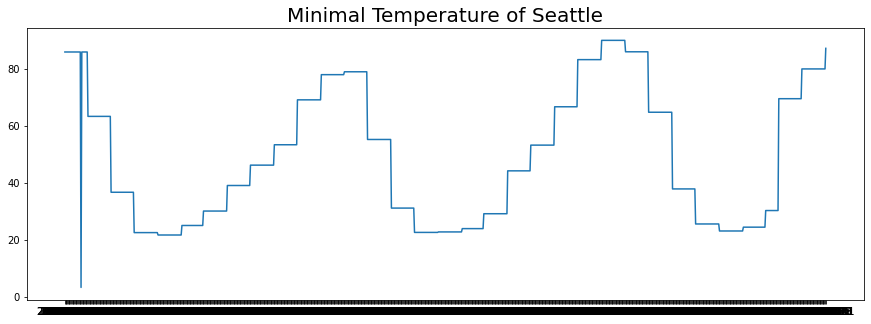

In [9]:
dates = df['Date'].values
rates = df['Hydro Generation Actual (in MU)'].values
rates = rates.astype(float)
 
plt.figure(figsize=(15,5))
plt.plot(dates, rates)
plt.title('Minimal Temperature of Seattle',
          fontsize=20);

In [10]:
#mae acuan
mae10 = (max(rates) - min(rates))*0.1
mae10

8.665

In [11]:
#splitting training and test set
x_train = dates[:int(dates.shape[0]*0.8)]
x_test = dates[int(dates.shape[0]*0.8):]
y_train = rates[:int(dates.shape[0]*0.8)]
y_test = rates[int(dates.shape[0]*0.8):]

In [12]:
#defining window function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
#assign test and train set
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [14]:
#create sequential model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [15]:
#compile
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
#callback function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae')<mae10 and logs.get('mae')<mae10):
      print("\nMAE telah mencapai < 10% skala data!")
      self.model.stop_training = True
callbacks = myCallback()

In [17]:
#train data
history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=200,
                    callbacks=[callbacks])

Epoch 1/200
8/8 [==============================] - 7s 286ms/step - loss: 48.5522 - mae: 49.0522 - val_loss: 47.1636 - val_mae: 47.6636
Epoch 2/200
8/8 [==============================] - 1s 133ms/step - loss: 48.5408 - mae: 49.0408 - val_loss: 47.1493 - val_mae: 47.6493
Epoch 3/200
8/8 [==============================] - 1s 133ms/step - loss: 48.5238 - mae: 49.0238 - val_loss: 47.1321 - val_mae: 47.6321
Epoch 4/200
8/8 [==============================] - 1s 138ms/step - loss: 48.5074 - mae: 49.0074 - val_loss: 47.1138 - val_mae: 47.6138
Epoch 5/200
8/8 [==============================] - 1s 133ms/step - loss: 48.4872 - mae: 48.9872 - val_loss: 47.0951 - val_mae: 47.5951
Epoch 6/200
8/8 [==============================] - 1s 136ms/step - loss: 48.4686 - mae: 48.9686 - val_loss: 47.0762 - val_mae: 47.5762
Epoch 7/200
8/8 [==============================] - 1s 136ms/step - loss: 48.4479 - mae: 48.9479 - val_loss: 47.0573 - val_mae: 47.5573
Epoch 8/200
8/8 [==============================] - 1s 1